In [1]:
import os, sys
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

#from mitequinox.utils import *
#from mitequinox.binary import *
import xmitgcm as xm
from xmitgcm import llcreader
from fsspec.implementations.local import LocalFileSystem

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=2)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.1.14:48337 Dashboard: http://10.148.1.14:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
#data_dir = '/Users/aponte/code/mit_equinox/data'
#data_dir = '/home/datawork-lops-osi/equinox/mit4320/'
data_dir = '/home/c11-data/Test_aponte/aurelien/mit/'

### generate mask file

In [ ]:
ds = xm.open_mdsdataset('', grid_dir=data_dir+'grid/',
                        iters=None, geometry='llc',
                        default_dtype=np.dtype('>f4'),
                        read_grid=True,
                        ignore_unknown_vars=True,
                        llc_method="smallchunks")

In [ ]:
points = ['C', 'S', 'W']
ds_mask = (ds.reset_coords()[['mask'+p for p in points]]
           .rename({'mask'+p: 'mask_'+p.lower() for p in points})
          )
ds_mask

In [7]:
ds_mask.to_zarr(data_dir+'mask.zarr', 
                mode='w', consolidated=True)

### read data with llcreader

In [10]:
fs = LocalFileSystem()
store = llcreader.BaseStore(fs, base_path=data_dir+'data/', 
                            shrunk=True, 
                            mask_path=data_dir+'mask.zarr')
model = llcreader.LLC4320Model(store)

In [11]:
model

In [14]:
ds = model.get_dataset(varnames=['Eta'], iter_start=752688, iter_stop=752688+1)
#ds = model.get_dataset(varnames=['Eta'])


In [15]:
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 90, k_u: 90, time: 1)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    niter    (time) int64 ...
  * time     (time) datetime64[ns] 2012-04-14T19:00:00
Data variables:
    Eta      (time, face, j, i) float32 dask.array<chunksize=(1, 3, 4320, 4320), meta=np.ndarray>

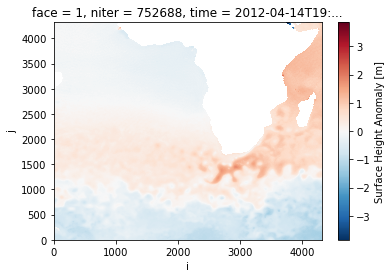

In [18]:
ds.Eta.isel(time=0,face=1, i=slice(0,None,4), j=slice(0,None,4)).plot()

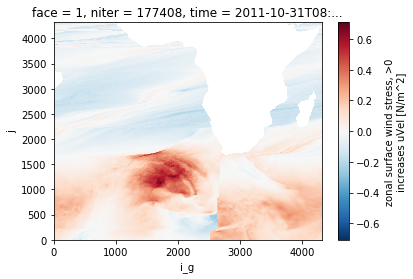

In [21]:
i=177408
ds = model.get_dataset(varnames=['oceTAUX'], iter_start=i, iter_stop=i+1)
ds.oceTAUX.isel(time=0,face=1, i_g=slice(0,None,4), j=slice(0,None,4)).plot()

In [22]:
model_portal = llcreader.ECCOPortalLLC4320Model()
ds = model_portal.get_dataset(k_chunksize=1)
print(ds)

KeyError: 'https://storage.googleapis.com/pangeo-ecco/llc/masks/llc_4320_masks.zarr/.zmetadata'

In [ ]:
ds = model_portal.get_dataset(varnames=['oceTAUX'], iter_start=i, iter_stop=i+1)
ds.oceTAUX.isel(time=0,face=1, i_g=slice(0,None,4), j=slice(0,None,4)).plot()

In [4]:
fname = data_dir+'grid/hFacC'
ds = xm.utils.read_mds(fname, endian='>', 
                 dtype=np.dtype('>f4'), use_dask=True, chunks="3D",
                 llc=True, llc_method="smallchunks", legacy=True)
#shape=(4320,56160,90),

In [5]:
ds

{'hFacC': dask.array<getitem, shape=(90, 56160, 4320), dtype=>f4, chunksize=(1, 56160, 4320), chunktype=numpy.ndarray>}

In [6]:
ds_da = ds['hFacC'].persist() # hangs?

In [7]:
# 130MiB total
ds_da.mean().compute()

KeyboardInterrupt: 

In [69]:
cluster.close()

distributed.utils - ERROR - "('mds-9adb683cd53b07c1b5e122b6ec4f17e8', 0, 49, 0, 0)"
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/scheduler.py", line 2535, in gather
    ts = self.tasks[key]
KeyError: "('mds-9adb683cd53b07c1b5e122b6ec4f17e8', 0, 49, 0, 0)"
distributed.core - ERROR - "('mds-9adb683cd53b07c1b5e122b6ec4f17e8', 0, 49, 0, 0)"
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/core.py", line 403, in handle_comm
    result = await result
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/scheduler.py", line 2535, in gather
    ts = self.tasks[key]
KeyError: "('mds-9adb683cd53b07c1b5e122b6ec4f17e8', 0, 49, 0, 0)"
distributed.client 

In [13]:
ds = xm.open_mdsdataset('', grid_dir=data_dir+'grid/',
                        iters=None, geometry='llc',
                        default_dtype=np.dtype('>f4'),
                        read_grid=True,
                        ignore_unknown_vars=True,
                        llc_method="smallchunks")

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/xmitgcm/mds_store.py:837: UserWarning: Couldn't find available_diagnostics.log in  or /home/c11-data/Test_aponte/aurelien/mit/grid/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))


In [14]:
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89 90
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XG       (face, j_g, i_g) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YG       (face, j_g, i_g) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    CS       (face, j, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SN       (face, j, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Z        (k) >f4 -0.5 -1.57 -2.79 -4.185 ... -5881.88 -6301.185 -6760.17
    Zp1      (k_p1) >f4 0.0 -1.0 -2.14 -3.44 ... -6082.07 -6520.3 -7000.04
    Zu       (k_u) >f4 -1.0 -2.14 -3.44 -4.93 ... -6082.07 -6520.3 -7000.04
    Zl       (k_l) >f4 0.0 -1.0 -2.14 -3.44 ... -5681.69 -6082.07 -6520.3
    rA       (face, j, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxG      (face, j_g, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyG      (face, j, i_g) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz      (face, j_g, i_g) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxC      (face, j, i_g) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyC      (face, j_g, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAw      (face, j, i_g) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAs      (face, j_g, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    drC      (k_p1) >f4 0.5 1.07 1.22 1.395 ... 383.155 419.305 458.985 239.87
    drF      (k) >f4 1.0 1.14 1.3 1.49 1.7 ... 365.93 400.38 438.23 479.74
    PHrefC   (k) >f4 4.905 15.4017 27.3699 ... 57701.242 61814.625 66317.266
    PHrefF   (k_p1) >f4 0.0 9.81 20.9934 ... 59665.105 63964.145 68670.39
    hFacC    (k, face, j, i) >f4 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    hFacW    (k, face, j, i_g) >f4 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    hFacS    (k, face, j_g, i) >f4 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    maskC    (k, face, j, i) bool dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    maskW    (k, face, j, i_g) bool dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    maskS    (k, face, j_g, i) bool dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/home/c11-dat...

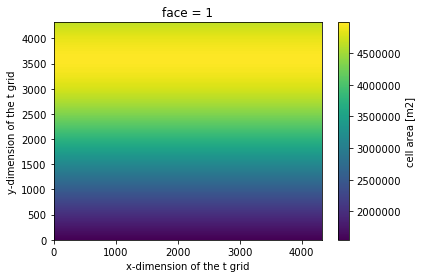

In [15]:
ds.rA.isel(face=1).plot()

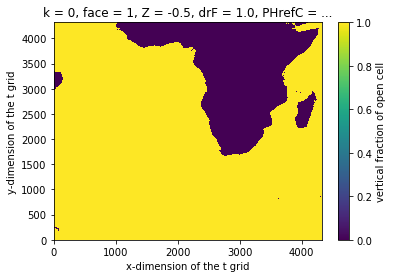

In [16]:
ds.hFacC.isel(face=1, k=0).plot()

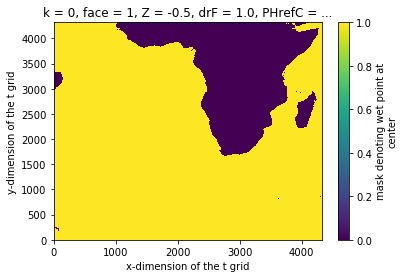

In [17]:
# ds.hFacS.isel(face=1, k=0).plot() # error: No such file or directory:
ds.maskC.isel(face=1, k=0).plot()

In [18]:
points = ['C', 'S', 'W']
#['maskC', 'maskS', 'maskE']
#ds['maskC', 'maskS']]
ds_mask = (ds.reset_coords()[['mask'+p for p in points]]
           .rename({'mask'+p: 'mask_'+p.lower() for p in points})
          )
ds_mask

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    mask_c   (k, face, j, i) bool dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    mask_s   (k, face, j_g, i) bool dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    mask_w   (k, face, j, i_g) bool dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/home/c11-dat...

In [19]:
ds_mask.nbytes/1e9

65.505163064

In [20]:
data_dir

'/home/c11-data/Test_aponte/aurelien/mit/'

In [21]:
ds_mask.to_zarr(data_dir+'mask.zarr', mode='w')

In [22]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [46]:
# slow
ds_mask = ds_mask.isel(k=0).persist()

In [43]:
# slow
ds_mask = ds_mask.persist()

In [30]:
# slow
ds_mask.to_zarr(data_dir+'/tmp_debug/mask.zarr', 
                mode='w')

KeyboardInterrupt: 

In [29]:
# slow
ds_mask.to_zarr(data_dir+'/tmp_debug/mask.zarr', 
                mode='w', consolidated=True)

KeyboardInterrupt: 

In [22]:
fs = LocalFileSystem()
store = llcreader.BaseStore(fs, base_path=data_dir+'/tmp_debug/', 
                            shrunk=True, 
                            mask_path=data_dir+'/tmp_debug/grid.zarr')

In [23]:
model = llcreader.LLC4320Model(store)

KeyError: '/Users/aponte/code/mit_equinox/data/grid.zarr/.zmetadata'

In [14]:
model

In [17]:
ds = model.get_dataset(varnames=['Eta'], iter_start=28080, iter_stop=28080+1, iter_step=1)

In [18]:
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 90, k_u: 90, time: 1)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    niter    (time) int64 ...
  * time     (time) datetime64[ns] 2011-09-18T03:00:00
Data variables:
    Eta      (time, face, j, i) float32 dask.array<chunksize=(1, 3, 4320, 4320), meta=np.ndarray>

In [19]:
ds.Eta.isel(time=0,face=1).plot()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/aponte/code/mit_equinox/data/Eta.0000028080.data'

/Users/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/xmitgcm/mds_store.py:837: UserWarning: Couldn't find available_diagnostics.log in  or /Users/aponte/code/mit_equinox/data/grid. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))


In [34]:
(ds.drop(['hFacC', 'hFacW', 'hFacS'])
   .to_zarr(data_dir+'/grid/mask.zarr', 
            mode='w', consolidated=True)
)

ValueError: bytes offset 9.4805e+09 is greater than file size 6.70125e+09

In [3]:
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster()
#cluster = PBSCluster(cores=4, processes=2, memory='100G', resource_spec='select=1:ncpus=28:mem=110GB') #
#w = cluster.scale(20)

In [4]:
#out_dir = osi+'equinox/mit4320/zarr/'
#out_dir

'/home/datawork-lops-osi/equinox/mit4320/zarr/'

In [5]:
# zarr compression
# http://xarray.pydata.org/en/stable/io.html
# http://zarr.readthedocs.io/en/stable/tutorial.html#compressors
#compressor = None

---

# debug 

In [5]:
import dask
import xmitgcm as xm
#
def get_compressed_level_index(grid_dir, 
                               index_fname='llc4320_compressed_level_index.nc', 
                               geometry='llc'):
    ''' Some doc
    '''
    #
    ds = xm.open_mdsdataset('', grid_dir=grid_dir,
                             iters=None, geometry=geometry, read_grid=True,
                             default_dtype=np.dtype('>f4'),
                             ignore_unknown_vars=True)
    
    # get shape
    #nz, nface, ny, nx = ds.hFacC.shape
    #shape = (1, nface, ny, nx)
    
    try:
        ds_index = xr.open_dataset(grid_dir+index_fname)
    except OSError:
        # compute and save mask indices
        print('Create llc4320_compressed_level_index.nc in grid_dir')
        ds_index = ((ds.reset_coords()[['hFacC', 'hFacW','hFacS']] > 0).sum(axis=(1, 2, 3)))
        ds_index.coords['k'] = ds.k
        ds_index.load().to_netcdf(grid_dir+index_fname)
        print('done')

    return ds_index, ds

In [7]:
ds_index, ds = get_compressed_level_index(grid_dir)
ds

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/xmitgcm/mds_store.py:837: UserWarning: Couldn't find available_diagnostics.log in  or /home/datawork-lops-osi/equinox/mit4320/grid/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89 90
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XG       (face, j_g, i_g) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YG       (face, j_g, i_g) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    CS       (face, j, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SN       (face, j, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Z        (k) >f4 -0.5 -1.57 -2.79 -4.185 ... -5881.88 -6301.185 -6760.17
    Zp1      (k_p1) >f4 0.0 -1.0 -2.14 -3.44 ... -6082.07 -6520.3 -7000.04
    Zu       (k_u) >f4 -1.0 -2.14 -3.44 -4.93 ... -6082.07 -6520.3 -7000.04
    Zl       (k_l) >f4 0.0 -1.0 -2.14 -3.44 ... -5681.69 -6082.07 -6520.3
    rA       (face, j, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxG      (face, j_g, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyG      (face, j, i_g) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz      (face, j_g, i_g) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxC      (face, j, i_g) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyC      (face, j_g, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAw      (face, j, i_g) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAs      (face, j_g, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    drC      (k_p1) >f4 0.5 1.07 1.22 1.395 ... 383.155 419.305 458.985 239.87
    drF      (k) >f4 1.0 1.14 1.3 1.49 1.7 ... 365.93 400.38 438.23 479.74
    PHrefC   (k) >f4 4.905 15.4017 27.3699 ... 57701.242 61814.625 66317.266
    PHrefF   (k_p1) >f4 0.0 9.81 20.9934 ... 59665.105 63964.145 68670.39
    hFacC    (k, face, j, i) >f4 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    hFacW    (k, face, j, i_g) >f4 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    hFacS    (k, face, j_g, i) >f4 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    maskC    (k, face, j, i) bool dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    maskW    (k, face, j, i_g) bool dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    maskS    (k, face, j_g, i) bool dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/home/datawor...

In [7]:
ds = ds.isel(k=0).persist()

In [ ]:
_vars_datashrunk = ['Eta', 'oceTAUX', 'oceTAUY', 'KPPhbl']

def load_level_from_3D_field(data_dir, varname, inum, offset, count, mask, dtype):
    ''' Some doc
    '''

    # all iters in one directory:
    inum_str = '%010d' % inum
    if varname in _vars_datashrunk:
        suff = '.data.shrunk'
    else:
        suff = '.shrunk'            
    fname = os.path.join(data_dir, '%s.%s' % (varname, inum_str) +suff)
    
    with open(fname, mode='rb') as file:
        file.seek(offset * dtype.itemsize)
        data = np.fromfile(file, dtype=dtype, count=count)
    
    data_blank = np.full_like(mask, np.nan, dtype='f4')
    data_blank[mask] = data
    data_blank.shape = mask.shape
    data_llc = xm.utils._reshape_llc_data(data_blank, jdim=0).compute(scheduler=dask.get)
    data_llc.shape = (1,) + data_llc.shape
    return data_llc


def lazily_load_level_from_3D_field(data_dir, varname, inum, offset, count, mask, shape, dtype):
    ''' Some doc
    '''
    return dask.array.from_delayed(dask.delayed(load_level_from_3D_field)
                            (data_dir, varname, inum, offset, count, mask, dtype),
                            shape, dtype)


def get_compressed_data(varname, data_dir, grid_dir, ds_index=None, ds=None, iters='all', 
                        time=None, client=None, k=0, point='C', **kwargs):
    ''' Get mitgcm compressed data
    
    Parameters
    ----------
    varname: string
        Variable name to load (should allow for list?)
    data_dir: string
        Path to the directory where the mds .data and .meta files are stored
    grid_dir: string
        Path to the directory where grid files are stored
    ds_index: xarray Dataset, optional
        Contains compressed file
    iters: list, 'all', optional
        The iterations numbers of the files to be read. If 'all' (default), all iterations 
        will be read.
    k: int
        vertical level loaded
    point: string
        grid point used for the mask
    '''
    dtype = np.dtype('>f4')
    
    if ds_index is None or shape is None or ds is None:
        ds_index, ds = get_compressed_level_index(grid_dir, **kwargs)
        # get shape
        nz, nface, ny, nx = ds.hFacC.shape
        shape = (1, nface, ny, nx)        
        
    strides = [0,] + list(ds_index['hFac' + point].data)
    offset = strides[k]
    count = strides[k+1]
    
    if iters is 'all':
        iters = xm.mds_store._get_all_iternums(data_dir, file_prefixes=varname, 
                                               file_format='*.??????????.data.shrunk')
        
    # load mask from raw data
    hfac = xm.utils.read_mds(grid_dir + 'hFac' + point, llc=True, dtype=dtype,
                             use_mmap=False, use_dask=True, chunks='2D')['hFac'+point][k].compute()
    #hfac = xm.utils.read_mds(grid_dir + 'hFac' + point,
    #                         use_mmap=True, use_dask=False, chunks="2D") #, force_dict=False) 
    #hfac = xm.utils.read_mds(grid_dir + 'hFac' + point, llc=True,
    #                         use_mmap=True, use_dask=False, extra_metadata=llc4320)['hFac' + point]
    #                        use_mmap=True, use_dask=False, force_dict=False)['hFac' + point]
    #hfac = xm.utils.read_3d_llc_data(grid_dir + 'hFac'+point+'.data', 90, 4320, dtype='>f4', memmap=True)
    #mask = hfac[k]>0
    mask = hfac>0
    if client is None:
        mask_future = mask
    else:
        mask_future = client.scatter(mask)
    
    data = dask.array.concatenate([lazily_load_level_from_3D_field
                            (data_dir, varname, i, offset, count, mask_future, shape, dtype)
                            for i in iters], axis=0)

    if point is 'C':
        dims = ['time', 'face', 'j', 'i']
    elif point is 'W':
        dims = ['time', 'face', 'j', 'i_g']
    elif point is 'S':
        dims = ['time', 'face', 'j_g', 'i']    
    
    ds[varname] = xr.Variable(dims, data)   
    
    if time is not None:
        ds['time'] = time.sel(iters=iters).values
        #ds['dtime'] = iters_to_date(iters)
        ds = ds.assign_coords(dtime=xr.DataArray(iters_to_date(iters), dims=['time']))
        #ds = ds.assign(dtime=)
        
    return ds


def get_iters_time(varname, data_dir, delta_t=25.):
    ''' get iteration numbers and derives corresponding time
    Parameters
    ----------
    varname: string
        Variable name to load (should allow for list?)
    data_dir: string
        Path to the directory where the mds .data and .meta files are stored
    delta_t: float
        Model time step
    
    Returns
    -------
    iters: xarray DataArray
        iteration numbers indexed by time
    time: xarray DataArray
        time in seconds
    '''
    file_suff = '.shrunk'
    if varname in _vars_datashrunk:
        file_suff = '.data.shrunk'
    #
    iters = xm.mds_store._get_all_iternums(data_dir, file_prefixes=varname, 
                                           file_format='*.??????????'+file_suff)
    time = delta_t * np.array(iters)
    
    iters = xr.DataArray(iters, coords=[time], dims=['time'])
    time = xr.DataArray(time, coords=[iters.values], dims=['iters'])
    
    return iters, time

In [55]:
#V = ['Eta', 'SST', 'SSS', 'SSU', 'SSV']
V = ['oceTAUX', 'oceTAUY', 'KPPhbl'] # need to move files

# scheduler does not like (i.e. takes a long time to do anything) any spatial rechunking on top 
# of that on faces:
#Nc = 480 # x 9 = 4320
#Nc = 96 # x 45 = 4320
# other choices: 432, 27 (long scheduling), 288, 864

#out_dir = scratch+'/mit/standard/'
#scratchd = '/home/c11-data/Test_aponte/'
#out_dir = scratchd+'/mit/standard/'

# !!!
v = V[0]

#
data_dir = root_data_dir+'bin/'+v+'/'
# !!! should be removed eventually
data_dir = root_data_dir+'tmp/'
# !!!
iters, time = get_iters_time(v, data_dir, delta_t=25.)
#
p = 'C'
if v in ['SSU','oceTAUX']:
    p = 'W'
elif v is ['SSV','oceTAUY']:
    p = 'S'
#
ds = get_compressed_data(v, data_dir, grid_dir, iters=iters, time=time, client=client, point=p)
#
# should store grid data independantly in a single file
ds = ds.drop(['XC','YC','Depth','rA'])
#
#ds = ds.isel(time=slice(1000))
#ds = ds.chunk({'face': 1})
#ds = ds.chunk({'face': 1, 'i': Nc, 'j': Nc}) # scheduler does not like this
#
dv = ds[v].to_dataset()

# !!! tmp
dv = dv.isel(time=slice(0,10))
#

#
#dv = dv.chunk({'i': Nc, 'j': Nc}) # scheduler does not like this either
#
file_out = out_dir+'%s.zarr'%(v)
#try:
#    print(dv)
#    %time dv.to_zarr(file_out, mode='w')
#except:
#    print('Failure')
#dsize = getsize(file_out)
#print('   data is %.1fGB ' %(dsize/1e9))

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/xmitgcm/mds_store.py:837: UserWarning: Couldn't find available_diagnostics.log in  or /home/datawork-lops-osi/equinox/mit4320/grid/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))


In [56]:
dv

<xarray.Dataset>
Dimensions:  (face: 13, i_g: 4320, j: 4320, time: 10)
Coordinates:
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    dyG      (face, j, i_g) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxC      (face, j, i_g) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAw      (face, j, i_g) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 ... 2.88e+05 2.916e+05
    dtime    (time) datetime64[ns] 2011-09-13 ... 2011-09-13T09:00:00
Data variables:
    oceTAUX  (time, face, j, i_g) float32 dask.array<chunksize=(1, 13, 4320, 4320), meta=np.ndarray>

In [57]:
dv.to_zarr(file_out, mode='w')

---

# store grid

In [6]:
ds_index, ds = get_compressed_level_index(grid_dir)

# we will need to keep some of these when computing gradients
#ds = ds.drop(['dxG','dyG','dxC','dyC','rAw','rAs','rAz'])
#ds = ds.drop(['hFacC','hFacW','hFacS'])
#ds = ds.drop(['maskC','maskW','maskS'])
#ds = ds.drop(['Z', 'Zp1', 'Zu', 'Zl', 'drC', 'drF','PHrefC','PHrefF'])

#Nc = 432 # original choice
#Nc = 27 # very long scheduling
#Nc = 96 # 96*45
#ds = ds.chunk({'i': Nc, 'j': Nc, 'i_g': Nc, 'j_g': Nc})

print(ds)

/home1/datahome/aponte/xmitgcm/xmitgcm/mds_store.py:740: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/aponte/xmitgcm/xmitgcm/utils.py:336: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89 90
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) >f4 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XG      

In [7]:
# this way too slow, this may be optimized at xmitgcm calls
ds = ds.isel(k=0).persist()
#ds.rAw.isel(face=1).plot()

In [ ]:
file_out = out_dir+'grid.zarr'
%time ds.to_zarr(file_out, mode='w')
file_out

--- 

# standard data layout: chunks (face, time, j, i) = (1, 1, 4320, 4320)

In [5]:
#V = ['Eta', 'SST', 'SSS', 'SSU', 'SSV']
V = ['oceTAUX', 'oceTAUY', 'KPPhbl']

# scheduler does not like (i.e. takes a long time to do anything) any spatial rechunking on top 
# of that on faces:
#Nc = 480 # x 9 = 4320
#Nc = 96 # x 45 = 4320
# other choices: 432, 27 (long scheduling), 288, 864

#out_dir = scratch+'/mit/standard/'
#scratchd = '/home/c11-data/Test_aponte/'
#out_dir = scratchd+'/mit/standard/'

for v in V:
    #
    data_dir = root_data_dir+v+'/'
    # !!! should be removed eventually
    data_dir = root_data_dir+'tmp/'
    # !!!    
    iters, time = get_iters_time(v, data_dir, delta_t=25.)
    #
    p = 'C'
    if v in ['SSU','oceTAUX']:
        p = 'W'
    elif v is ['SSV','oceTAUY']:
        p = 'S'
    #
    ds = get_compressed_data(v, data_dir, grid_dir, iters=iters, time=time, client=client, point=p)
    #
    # should store grid data independantly in a single file
    ds = ds.drop(['XC','YC','Depth','rA'])
    #
    #ds = ds.isel(time=slice(1000))
    #ds = ds.chunk({'face': 1})
    #ds = ds.chunk({'face': 1, 'i': Nc, 'j': Nc}) # scheduler does not like this
    #
    dv = ds[v].to_dataset()
    #
    #dv = dv.chunk({'i': Nc, 'j': Nc}) # scheduler does not like this either
    #
    file_out = out_dir+'%s.zarr'%(v)
    try:
        #print(dv)
        %time dv.to_zarr(file_out, mode='w')                    
    except:
        print('Failure')
    dsize = getsize(file_out)
    print('   data is %.1fGB ' %(dsize/1e9))

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:735: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:336: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:249: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (face: 13, i_g: 4320, j: 4320, time: 1000)
Coordinates:
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    dyG      (face, j, i_g) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    dxC      (face, j, i_g) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    rAw      (face, j, i_g) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 ... 9.295e+06 9.299e+06
    dtime    (time) datetime64[ns] 2011-11-15 ... 2011-12-26T15:00:00
Data variables:
    SSU      (time, face, j, i_g) >f4 dask.array<shape=(1000, 13, 4320, 4320), chunksize=(1, 13, 4320, 4320)>
CPU times: user 1min 7s, sys: 3.44 s, total: 1min 10s
Wall time: 12min 49s
   data is 526.7GB 


---
# try to load standard lay out, rechunk and store right away


In [10]:
# parameters for rechunking

Nt = 24*10 # time chunks
#Nt = 0
#
Nt = len(ds.time) if Nt == 0 else Nt

Nc = 96 # x 45 = 4320
# other choices: 432, 27 (long scheduling), 288, 864

### one face at a time, all variables

In [12]:
# same but over all variables and faces
#V = ['SSU', 'SSV']
V = ['SSU']

out_dir = scratch+'mit/rechunked/'

for v in V:

    file_in = scratch+'/mit/standard/%s.zarr'%(v)
    ds0 = xr.open_zarr(file_in)
    
    #for face in range(ds0['face'].size):
    for face in [1]:
        
        ds = ds0.isel(face=face)
        #
        ds = ds.isel(time=slice(len(ds.time)//Nt *Nt))
        #
        ds = ds.chunk({'time': Nt, 'i': Nc, 'j': Nc})
        #
        # tmp, xarray zarr backend bug: 
        # https://github.com/pydata/xarray/issues/2278
        del ds['face'].encoding['chunks']
        del ds[v].encoding['chunks']
        
        file_out = out_dir+'%s_f%02d.zarr'%(v,face)
        try:
            #%time ds.to_zarr(file_out, mode='w')
            # specify compression:
            %time ds.to_zarr(file_out, mode='w', \
                             encoding={key: {'compressor': compressor} for key in ds.variables})
            # without compression: 601G for face 1
        except:
            print('Failure')
        dsize = getsize(file_out)
        print(' %s face=%d  data is %.1fGB ' %(v, face, dsize/1e9))


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 8min 24s, sys: 23.9 s, total: 8min 48s
Wall time: 14min 49s
 SSU face=1  data is 628.6GB 


---

In [17]:
w = cluster.start_workers(10)

In [6]:
client.restart()

distributed.scheduler - ERROR - Not all workers responded positively: ['timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out']
NoneType: None
distributed.client - ERROR - Restart timed out after 20.000000 seconds


Client Scheduler: tcp://10.148.1.12:42619 Dashboard: http://10.148.1.12:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


distributed.scheduler - ERROR - '1846309'
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '1846309'
distributed.scheduler - ERROR - '1846313'
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/scheduler.py", line 1306, in add_worker
    plugin.add_worker(scheduler=self, worker=address)
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/core.py", line 62, in add_worker
    self.running_jobs[job_id] = self.pending_jobs.pop(job_id)
KeyError: '1846313'
distributed.scheduler - ERROR - '1846313

In [13]:
# kill scheduler, workers
cluster.close()
#cluster.stop_workers(cluster.jobs)

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1283, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1012, in _reconnect
    await self._close()
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/cli